In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path 
import json

from tqdm.auto import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import cumtrapz

import jax 
import jax.numpy as jnp

from rowing.analysis import geodesy, files, splits, garmin
from rowing.model import pico, dynamics, kalman

In [4]:
data_folder = Path("pico")

activity = files.read_fit_file(data_folder / '8585396211_ACTIVITY.fit')
activity_start_time = activity.time[0]
activity_start_delta = activity_start_time - pd.to_datetime(activity_start_time.date())

pico_data = pico.load_raw_pico_data(
    data_folder / 'capture_0062_full_gyro.json'
)
accelgyro_data, valid_gps_data = pico.process_pico_data(pico_data)
accel_data, gyro_data = accelgyro_data[pico.accel_cols], accelgyro_data[pico.gyro_cols]

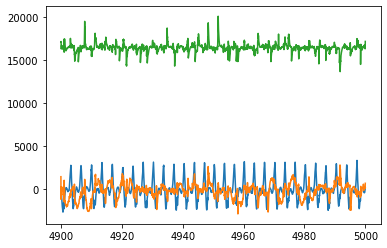

In [45]:
x, y, z = XYZ = dynamics.estimate_orientation(accel_data, gyro_data)

plt.plot(accel_data.dot(XYZ.T).loc[4900:5000].ewm(alpha=0.1).mean())

## Observed state

$$\begin{align*}
& \mathbf{a} = \{a_x, a_y, a_z\}, & \text{acceleration in recorder frame}
\\
& \boldsymbol{\omega} = \{\omega_x, \omega_y, \omega_z\}, & \text{angular acceleration in recorder frame}
\\
& \phi, & \text{latitude}
\\
& \theta, & \text{longitude}
\\
& v, & \text{horizontal speed}
\\
& \beta & \text{bearing}
\end{align*}$$


$$\mathbf{y}_t = \{\mathbf{a}, \boldsymbol{\omega}, \phi, \theta, v, \beta\}$$



## System State

at time, $t_k$, define system state,

$$\begin{align*}
& \phi_k & \text{latitude}
\\
& \theta_k & \text{longitude}
\\
& v^0_k & \text{average horizontal speed}
\\
& b_k & \text{bearing}
\\ & 
n_k & \text{total stroke phase}
\\ & 
s_k & \text{stroke rate}
\\ & 
\mathbf{c}_k = \{c^1_k,  c_k^2, ...\} & \text{stroke acceleration amplitudes}
\\ & 
\mathbf{d}_k = \{d_k^1,  d_k^2, ...\} & \text{stroke acceleration amplitudes}
\\ & 
\mathbf{e}_k = \{e_k^x, e_k^y, e_k^z\} & \text{recorder euler angles}
\\ & 
\mathbf{f}_k = \{r_k^x, r_k^y, r_k^z\} & \text{acceleration axes 0 offset}
\\ & 
\mathbf{r}_k = \{r_k^x, r_k^y, r_k^z\} & \text{acceleration axes scales}
\\ & 
\mathbf{g}_k = \{g_k^x, g_k^y, g_k^z\} & \text{gyro 0 offset}
\end{align*}$$

## Dynamical Model 

Define the transition model, 

$$\begin{align*}
\Delta t &= t_{k+1} - t_k
\\
n_{k + 1} &= n_{k} + s \Delta t
\\
a_{k + 1} &= \sum_j 
c_j \cos(2\pi j n_{k + 1})
+ d_j \sin(2\pi j n_{k + 1}) 
\\
v_{k + 1} &= v_0 + \sum_j \left(
\frac{c_j}{2\pi j s} \sin(2\pi j n_{k + 1}) 
- \frac{d_j}{2\pi j s} \cos(2\pi j n_{k + 1})
\right)
\\t
\Delta x_k &= v_0 \Delta t - \sum_j \left(
\frac{c_j}{(2\pi j s)^2} \cos(2\pi j n_{k + 1}) 
+ \frac{d_j}{(2\pi j s)^2} \sin(2\pi j n_{k + 1})
\right. \\
& \left.
- \frac{c_j}{(2\pi j s)^2} \cos(2\pi j n_{k}) 
- \frac{d_j}{(2\pi j s)^2} \sin(2\pi j n_{k})
\right) 
\\
\delta_k &= \frac{\Delta x_k}{R_\text{earth}}
\\
\phi_{k+1} &= 
\arcsin\left(
    \sin \phi_k \cos \delta_k + \cos \phi_k \sin \delta_k \cos \beta_k
\right)
\\
\theta_{k+1} &=
\theta_k + \arctan2(
    \sin \beta_k \sin \delta_k \cos \phi_k, \cos \delta_k - \sin \phi_k \sin \phi_{k+1}
)
\\
s_{k+1}, b_{k+1} &= s_k, b_{k}
\\
\mathbf{c}_{k+1}, \mathbf{d}_{k+1}
&= 
\mathbf{c}_{k}, \mathbf{d}_{k}
\\
\mathbf{e}_{k+1}, \mathbf{r}_{k+1}, \mathbf{g}_{k+1}
&= 
\mathbf{e}_{k}, \mathbf{r}_{k}, \mathbf{g}_{k}
\end{align*}$$


## Observation Model
Defining the dense rotation matrix from the set of Euler angles, 
$$\boldsymbol{O}(d_1, d_2, d_3) = \\
\begin{bmatrix} 
\cos d_1\cos d_3-\cos d_2\sin d_1\sin d_3&-\cos d_1\sin d_3-\cos d_2\cos d_3\sin d_1&\sin d_1\sin d_2
\\
\cos d_3\sin d_1+\cos d_1\cos d_2\sin d_3&\cos d_1\cos d_2\cos d_3-\sin d_1\sin d_3&-\cos d_1\sin d_2
\\
\sin d_2\sin d_3&\cos d_3\sin d_2&\cos d_2
\end{bmatrix}$$

We can then define the observation model

$$\begin{align*}
\mathbf{a} &=
\text{diag}(\boldsymbol{r}) \cdot \boldsymbol{O}(d_1, d_2, d_3) \cdot [a_t, 0, g] + \boldsymbol{\epsilon}_a
\\
\phi &= \phi_t + \boldsymbol{\epsilon}_\phi
\\
\theta &= \theta_t + \boldsymbol{\epsilon}_\theta
\\
v &= v_t + \boldsymbol{\epsilon}_v
\\
\beta &= \beta_t + \boldsymbol{\epsilon}_\beta
\end{align*}$$

where
$$
\boldsymbol{\epsilon}_\kappa \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma}_\kappa)
$$

Is the observation noise

In [129]:
from scipy import integrate, stats 

array([-0.15541111,  0.26876153, -0.70316865, ...,  0.07202717,
        0.00278763, -0.02798523])

In [ ]:
scipy.stats.ewm

In [159]:
def make_walk(size, alpha=0.1):
    walk = stats.norm.rvs(size=size).cumsum()
    walk -= pd.Series(walk).ewm(alpha=0.01).mean().values
    return walk


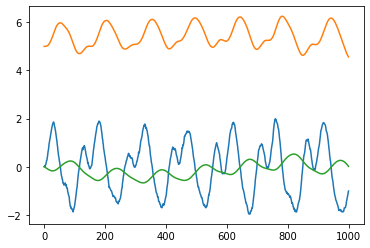

In [185]:
m = 1000
cs = (
    np.array([5, -3, -2]) / 5 
    + np.c_[make_walk(m), make_walk(m), make_walk(m)]/50
)
ds = (
    np.array([4, -1, -1]) / 5 
    + np.c_[make_walk(m), make_walk(m), make_walk(m)]/50
)
v0 = 5.
s = 20/60 + make_walk(m)/500
ts = np.linspace(0, 20, m)
ns = np.r_[0, integrate.cumtrapz(s, ts)]

j = np.arange(1, 4)

a = (
    cs * np.cos(2 * np.pi * j * ns[:, None])
    + ds * np.sin(2 * np.pi * j * ns[:, None])
).sum(1)

v = np.r_[0, integrate.cumtrapz(a, ts)] + v0 
x = np.r_[0, integrate.cumtrapz(v, ts)]


plt.plot(a)
plt.plot(v)
plt.plot(x - ts * v.mean())
